# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Prase-XML" data-toc-modified-id="Prase-XML-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Prase XML</a></div><div class="lev1 toc-item"><a href="#Word-Segmentation" data-toc-modified-id="Word-Segmentation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Word Segmentation</a></div>

# Prase XML

In [67]:
from xml.dom.minidom import parse
import xml.dom.minidom
import json
import os

In [39]:
DOMTree = xml.dom.minidom.parse("/Users/lizhn7/Downloads/EXPERIMENT/COPA/LM/data/copa-all.xml")
items = DOMTree.documentElement.getElementsByTagName('item')

In [52]:
index = []
asksFor = []
label = []
premise = []
alternative1 = []
alternative2 = []
wholeSent1 = []
wholeSent2 = []

In [62]:
for item in items:
    index.append(item.getAttribute('id'))
    asksFor.append(item.getAttribute('asks-for'))
    label.append(item.getAttribute('most-plausible-alternative'))
    premise.append(item.getElementsByTagName('p')[0].childNodes[0].data)
    alternative1.append(item.getElementsByTagName('a1')[0].childNodes[0].data)
    alternative2.append(item.getElementsByTagName('a2')[0].childNodes[0].data)
    if asksFor[-1] == 'cause':
        wholeSent1.append(alternative1[-1] + ' ' + premise[-1])
        wholeSent2.append(alternative2[-1] + ' ' + premise[-1])
    else:
        wholeSent1.append(premise[-1] + ' ' + alternative1[-1])
        wholeSent2.append(premise[-1] + ' ' + alternative2[-1])

In [68]:
tupe = (index, asksFor, label, premise, alternative1, alternative2, wholeSent1, wholeSent2)

- **Save Data**

In [70]:
def write_to_file(content, name):
    with open(name, 'a', encoding='utf-8') as f:
        f.write(json.dumps(content, ensure_ascii=False) + '\n')
        f.close()
        
def gen_data(data):
    for i in range(1000):
        yield {
            'index': data[0][i],
            'asks-for': data[1][i],
            'most-plausible-alternative': data[2][i],
            'premise': data[3][i],
            'alternative1': data[4][i],
            'alternative2': data[5][i],
            'whole-sentence1': data[6][i],
            'whole-sentence2': data[7][i]
        }

for i in gen_data(tupe):
    write_to_file(i, '/Users/lizhn7/Downloads/EXPERIMENT/COPA/LM/data/copa-all.json')

- **Load Data**

In [71]:
def load_data(path, name):
    """
    Load date from file
    """
    data = []
    input_file = os.path.join(path)
    with open(input_file) as f:
        lines = f.readlines()
    for line in lines:
        item = json.loads(line)
        data.append(item[name])
    return data

In [190]:
wholeSent1 = load_data('/Users/lizhn7/Downloads/EXPERIMENT/COPA/LM/data/copa-all.json', 'whole-sentence1')
wholeSent2 = load_data('/Users/lizhn7/Downloads/EXPERIMENT/COPA/LM/data/copa-all.json', 'whole-sentence2')

# Word Segmentation

In [94]:
from nltk import regexp_tokenize
from nltk import WordNetLemmatizer
import numpy as np
from tqdm import tqdm

In [74]:
def cut(s):
    """
    Word segmentation
    """
    pattern = r'''
              (?x)                   # set flag to allow verbose regexps 
              (?:[A-Z]\.)+           # abbreviations, e.g. U.S.A. 
              |\d+(?:\.\d+)?%?       # numbers, incl. currency and percentages 
              |\w+(?:[-&']\w+)*      # words w/ optional internal hyphens/apostrophe  
           '''  
    return regexp_tokenize(s, pattern=pattern)

In [191]:
ws1Words = [cut(s) for s in wholeSent1]
ws2Words = [cut(s) for s in wholeSent2]

In [198]:
ws1Words[0] + [0]*3

['The',
 'sun',
 'was',
 'rising',
 'My',
 'body',
 'cast',
 'a',
 'shadow',
 'over',
 'the',
 'grass',
 0,
 0,
 0]

In [201]:
A1 = []
A2 = []
for i in range(1000):
    a1 = []
    a2 = []
    length = max(len(ws1Words[i]), len(ws2Words[i]))
    ws1Words[i] += [0]*(length-len(ws1Words[i]))
    ws2Words[i] += [0]*(length-len(ws2Words[i]))
    for j in range(length):
        if ws1Words[i][j] != ws2Words[i][j]:
            a1.append(ws1Words[i][j])
            a2.append(ws2Words[i][j])
    A1.extend(a1)
    A2.extend(a2)

In [203]:
A1.extend(A2)

In [205]:
aaa = [i for i in A1 if i != 0]

In [206]:
len(aaa)

9990

In [209]:
aaa[0].lower()

'sun'

In [210]:
result = []
w = []
for i in range(len(aaa)):
    try:
        result.append(word2index[aaa[i].lower()])
    except KeyError:
        print(aaa[i])

humanitarian's
pruny
dry-cleaned
chandelier's
humanitarian's
humanitarian's
pruny


In [212]:
(result)

913645

In [200]:
length

1000

In [152]:
wnl = WordNetLemmatizer()
contWords = [[wnl.lemmatize(t.lower()) for t in toks] for toks in tqdm(Words)]

100%|██████████| 2000/2000 [00:00<00:00, 164660.08it/s]


In [96]:
sentLens = np.array([len(i) for i in contWords])
print('Number of sentences: \t{:d}'.format(len(sentLens)))
print('Distribution of sentence lengths (number of words):')
print('Min: {:d}   Max: {:d}   Mean: {:.3f}   Med: {:.3f}'.format(np.min(sentLens), np.max(sentLens), np.mean(sentLens), np.median(sentLens)))

Number of sentences: 	2000
Distribution of sentence lengths (number of words):
Min: 5   Max: 22   Mean: 11.239   Med: 11.000


- **Load Dictionarie**

In [89]:
import pickle

In [150]:
with open('/Users/lizhn7/Downloads/EXPERIMENT/COPA/LM/data/index.pkl', 'rb') as fp:
    word2index, index2word = pickle.load(fp)

In [151]:
len(word2index)

1060614

In [153]:
result = []
w = []
for c in contWords:
    try:
        result.append([word2index[i] for i in c])
    except KeyError:
        w.append(c)

In [173]:
[' '.join(ww) for ww in w]

['the man caught his shirtsleeve on the rungs of the fence he hopped the fence',
 "the humanitarian was difficult for the journalist to interview the journalist wrote a biography about the humanitarian's life",
 "he took a long shower the boy's fingers became pruny",
 'the man stained his suit he got it dry-cleaned',
 "i yanked the imposter's hair her wig came off",
 'the printer was low on ink the document printed out illegibly',
 'the man unlaced his shoes the shoes loosened',
 "the chandelier's lights flickered on and off the chandelier shattered on the floor",
 'the man caught his shirtsleeve on the rungs of the fence the sleeve ripped',
 "the journalist was intrigued by the humanitarian's work the journalist wrote a biography about the humanitarian's life",
 "he lathered his hands with soap the boy's fingers became pruny",
 "i yanked the imposter's hair she went bald",
 'the print was out of paper the document printed out illegibly',
 'the man unlaced his shoes the shoes became wo

humanitarian's pruny dry-cleaned imposter's illegibly unlaced chandelier's

In [218]:
wnl.lemmatize("broken", pos='v')

'break'

In [184]:
word2index['dry-clean']

369975

In [155]:
len(w)

14

In [157]:
for c in w:
    for i in c:
        try:
            word2index[i]
        except KeyError:
            print(i)

shirtsleeve
humanitarian's
pruny
dry-cleaned
imposter's
illegibly
unlaced
chandelier's
shirtsleeve
humanitarian's
humanitarian's
pruny
imposter's
illegibly
unlaced


In [160]:
result

[[1, 1045, 21, 2579, 39, 428, 1697, 5, 3045, 85, 1, 4798],
 [1,
  664,
  977,
  64,
  803,
  21,
  148,
  120,
  5,
  399,
  57,
  1,
  664,
  18896,
  64,
  15851,
  1038,
  2518],
 [1, 4799, 17820, 6, 5, 41, 995, 1, 345, 1252, 8, 1218],
 [1, 3640, 5693, 219, 4574, 1, 5374, 4976, 6026],
 [11, 21, 5, 1837, 392, 1, 2282, 4, 1, 392, 12988, 548, 1, 7457],
 [30, 1986, 2037, 787, 2118, 1, 7289, 634, 1, 1692],
 [12, 21473, 1, 3369, 1, 11410, 355, 47, 4, 1, 3369],
 [30, 9048, 1, 19539, 1, 231, 206, 5, 2928, 10, 38, 11392],
 [1, 7341, 77810, 1, 2381, 1, 2381, 1985, 5, 31041, 3786, 185, 1, 7341],
 [1, 655, 4002, 339071, 1, 1110, 1, 1110, 1985, 5, 4355, 13, 1, 617, 1022],
 [1, 22002, 21, 27170, 1, 664, 14636, 64, 22002],
 [1, 5528, 664, 3082, 5, 6217, 1, 11114, 1485, 355, 85, 2, 1104, 64, 248],
 [1, 8376, 26991, 85, 8, 1, 1754, 77, 39713, 10, 1, 8376],
 [1, 14802, 9642, 14167, 76, 21, 1003, 95, 2, 3047],
 [12, 9502, 307, 10, 39, 4130, 803, 39, 803, 26191],
 [64, 803, 3076, 32, 1375, 9226, 145, 6

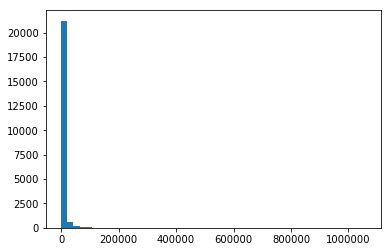

In [166]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(sum(result, []), bins=50);

In [169]:
sentLens = sum(result, [])

In [214]:
sentLens = result

In [215]:
for i in range(10000, 60000, 1000):
    c = 0
    for d in sentLens:
        if d <= i:
            c+=1
    print(i)
    print(c/len(sentLens))
    print('——————————————————————————')

10000
0.8732845837924471
——————————————————————————
11000
0.8833016127416609
——————————————————————————
12000
0.8907142141640789
——————————————————————————
13000
0.8981268155864971
——————————————————————————
14000
0.9059400981668837
——————————————————————————
15000
0.9116498046679354
——————————————————————————
16000
0.9161574676950817
——————————————————————————
17000
0.9207653010117199
——————————————————————————
18000
0.9262746669337875
——————————————————————————
19000
0.9320845437243314
——————————————————————————
20000
0.9351898226985876
——————————————————————————
21000
0.9395973154362416
——————————————————————————
22000
0.9419012320945608
——————————————————————————
23000
0.9445056596213564
——————————————————————————
24000
0.9483121306220575
——————————————————————————
25000
0.9505158769908845
——————————————————————————
26000
0.9524191124912351
——————————————————————————
27000
0.9553240508865071
——————————————————————————
28000
0.9577281378343183
——————————————————————————
29000
0.9591

In [171]:
print('Min: {:d}   Max: {:d}   Mean: {:.3f}   Med: {:.3f}'.format(np.min(sentLens), np.max(sentLens), np.mean(sentLens), np.median(sentLens)))

Min: 1   Max: 1059886   Mean: 4633.907   Med: 255.000


In [ ]:
np.meanasum(result, [])

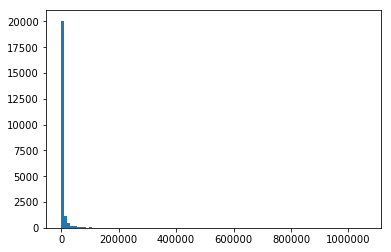

In [168]:
plt.hist(sum(result, []), bins=100);

In [130]:
[[word2index[i] for i in c] for c in w]

KeyError: "humanitarian's"

In [158]:
wnl.lemmatize("shirtsleeve")

'shirtsleeve'